In [6]:
import pandas as pd
import numpy as np
import requests
import time
from tqdm import tqdm
import glob, copy
from datetime import datetime
import seaborn as sns
import math 
import networkx as nx
from collections import Counter
import statsmodels.api as sm

# for plotting 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

## m-EPR

In [5]:
class MEPRModel:
    def __init__(self, num_locations, num_users, 
                 pref_return = True, mu_val = 0.6, gamma_val = 0.5):
        self.num_locations = num_locations
        self.num_users = num_users
        
        self.pref_return = pref_return
        self.mu_val = mu_val
        self.gamma_val = gamma_val
        
        ## initialize users based on locations
        self.curr_loc_idx = list(np.random.choice(range(self.num_locations), num_users))
        self.n_users_location = [0]*num_locations
        self.unique_locs_seen = [[] for _ in range(num_users)]
        self.n_locations_seen = [1]*num_users
        
        self.locations = [[] for _ in range(num_users)]
        
        for i, j in enumerate(self.curr_loc_idx):
            self.n_users_location[j]+=1
            self.locations[i].append(j)
            self.unique_locs_seen[i].append(j)
            
        ## visitors counter
        self.visitor_counts = Counter(self.curr_loc_idx)
        
        ## initialize activity -- can be estimated directly from data; 
        ## the prob of visitation is not influenced by this parameter
        self.exponent = 2.5

        # Generate sample from a power-law distribution
        self.pr_jump = 1 - np.random.power(self.exponent, num_users)

    
    def select_loc_preferentially(self, num_steps_per_turn = 1):
        locs_l = range(len(self.n_users_location))
        n_users = np.array(self.n_users_location)
        b = n_users/sum(n_users)
        
        return np.random.choice(locs_l, p = b)
                
    def preferential_return(self, idx, num_steps_per_turn = 1, use_pa = True):
        if use_pa:
            locs_l = self.unique_locs_seen[idx]
            n_users = np.array([self.n_users_location[i] for i in locs_l])
            b = n_users/sum(n_users)
            return np.random.choice(locs_l, num_steps_per_turn, p = b)
        else:
            idx_counter = Counter(self.locations[idx])
            a, b = list(idx_counter.keys()), np.array(list(idx_counter.values()))
            b = b/np.sum(b)
            return np.random.choice(a, p = b)
    
    def choose_next_location(self, idx, num_steps_per_turn = 4):
        pnew = self.mu_val*np.power(self.n_locations_seen[idx], -self.gamma_val)
        
        explore = np.random.rand() < pnew
        
        if explore:
            # Explore a new location
            select_loc = self.select_loc_preferentially()
            ## keep sampling until you see a new one
            while select_loc in self.unique_locs_seen[idx]:
                select_loc = self.select_loc_preferentially()
                             
            self.n_locations_seen[idx]+=1
            if select_loc not in self.unique_locs_seen[idx]:
                self.unique_locs_seen[idx].append(select_loc)
            
            self.locations[idx].append(select_loc)
            self.n_users_location[select_loc]+=1

        else:            
            if self.pref_return:
                # Preferentially return to a previously visited location
                select_locs = self.preferential_return(idx, num_steps_per_turn)
                self.locations[idx].extend(select_locs)
                
                for l_id in select_locs:
                    self.n_users_location[l_id]+=1

            else:
                select_loc = np.random.choice(self.unique_locs_seen)
        
        
    def simulate(self, num_steps, num_steps_per_turn = 4, disable_bar = False):
        
        for i in tqdm(range(num_steps), disable=disable_bar):
            random_vals = np.random.random(len(self.pr_jump))
            inds_to_jump = np.where(random_vals >= self.pr_jump)[0]
            
            for j in inds_to_jump:
                self.choose_next_location(j, num_steps_per_turn)
            
            ## update the locations visitors counters 
            self.visitor_counts = Counter(self.n_users_location)
        #return self.locations, self.n_locations_seen

In [5]:
## run the simulation for locations, users, and parameter values....
u_mepr = MEPRModel(20000, 5000, mu_val = 0.85, gamma_val = 0.41)
u_mepr.simulate(300, 4)

100%|██████████| 300/300 [30:38<00:00,  6.13s/it]


In [6]:
location_users_mepr = u_mepr.locations
mepr_visited_users = pd.DataFrame({"user_id":range(len(location_users_mepr)),'user_locs':location_users_mepr})
mepr_visited_users.head()

,user_id,user_locs
0,0,"[19373, 4381, 7858, 4381, 7858, 4381, 4381, 11..."
1,1,"[18982, 11601, 19165, 19165, 11601, 11601, 191..."
2,2,"[1770, 9961, 9112, 17555, 9961, 17555, 9961, 1..."
3,3,"[11761, 3795, 13426, 3591, 7777, 9839, 13426, ..."
4,4,"[11968, 15241, 15241, 15241, 15241, 15241, 152..."


In [5]:
u_mepr2 = MEPRModel(20000, 5000, mu_val = 0.8, gamma_val = 0.07)
u_mepr2.simulate(100, 4)

100%|██████████| 100/100 [24:10<00:00, 14.51s/it]


In [7]:
u_mepr3 = MEPRModel(20000, 5000, mu_val = 0.8, gamma_val = 0.18)
u_mepr3.simulate(100, 4)

100%|██████████| 100/100 [16:05<00:00,  9.65s/it]


# Individual metrics

In [81]:
location_users_pepr = u_mepr.locations
mepr_visited_users = pd.DataFrame({"user_id":range(len(location_users_pepr)),'user_locs':location_users_pepr})
mepr_visited_users.head()

location_users_pepr = u_mepr2.locations
mepr_visited_users_2 = pd.DataFrame({"user_id":range(len(location_users_pepr)),'user_locs':location_users_pepr})

location_users_pepr = u_mepr3.locations
mepr_visited_users_3 = pd.DataFrame({"user_id":range(len(location_users_pepr)),'user_locs':location_users_pepr})

mepr_visited_users_3.head()

,user_id,user_locs
0,0,"[11329, 7338, 17553, 6977, 17553, 6977, 17553,..."
1,1,"[440, 10229, 10229, 10229, 440, 10229, 15020, ..."
2,2,"[19576, 19576, 19576, 19576, 19576, 558, 1507,..."
3,3,"[1044, 14272, 1344, 3397, 2722, 16453, 3397, 3..."
4,4,"[5410, 4950, 4950, 4950, 4950, 5410, 17108, 90..."


## 1) S* vs P(S*)

In [82]:
def get_visit_freq(df):
    df = df.groupby('user_id').locs_id.value_counts().to_frame()
    df['peer_address'] = df.index.get_level_values(0)
    df['point'] = df.index.get_level_values(1)
    df.index = range(len(df))
    df.columns = ['n_visits','peer_address','visited_parcel']

    df = df[df.n_visits>1]

    total_visits = df.groupby('peer_address').n_visits.sum().to_frame()
    total_visits['peer_address'] = total_visits.index
    total_visits.index = range(len(total_visits))
    total_visits.columns = ['total_visits','peer_address']
    total_visits.head()

    df = pd.merge(df, total_visits, how='left',on='peer_address')
    df['pr_visits'] = df.n_visits/df.total_visits
    #visitation_freq = visitation_freq[visitation_freq.peer_address.isin(tmp_traj_df.peer_address)]

    n_parc_visited_mepr = df.groupby('peer_address').visited_parcel.nunique().to_frame()
    n_parc_visited_mepr['peer_address'] = n_parc_visited_mepr.index
    n_parc_visited_mepr.index = range(len(n_parc_visited_mepr))
    n_parc_visited_mepr.columns = ['total_parcels_visited','peer_address']

    df = pd.merge(df, n_parc_visited_mepr, how='left',on='peer_address')
    
    return df 

def get_pr_visits_df(df):
    pr_visits_dict = {}
    for u in tqdm(df[df.total_parcels_visited>50].peer_address.unique()):
        t = df[df.peer_address == u]
        t = t.sort_values('pr_visits', ascending = False)

    #    t = t.iloc[:100]
        tot_val = t.n_visits.sum()
        t['pr_visits'] = t.pr_visits/tot_val

        for i, j in enumerate(t.pr_visits.tolist()):
            if i+1 not in pr_visits_dict:
                pr_visits_dict[i+1] = []
            pr_visits_dict[i+1].append(j)
    return pr_visits_dict    

In [83]:
visit_freq_df_mepr = mepr_visited_users[['user_id','user_locs']].explode('user_locs')
visit_freq_df_mepr.columns = ['user_id','locs_id']
visit_freq_df_mepr = get_visit_freq(visit_freq_df_mepr)
visit_freq_dict = get_pr_visits_df(visit_freq_df_mepr)


visit_freq_df_mepr_2 = mepr_visited_users_2[['user_id','user_locs']].explode('user_locs')
visit_freq_df_mepr_2.columns = ['user_id','locs_id']
visit_freq_df_mepr_2 = get_visit_freq(visit_freq_df_mepr_2)
visit_freq_dict_2 = get_pr_visits_df(visit_freq_df_mepr_2)

visit_freq_df_mepr_3 = mepr_visited_users_3[['user_id','user_locs']].explode('user_locs')
visit_freq_df_mepr_3.columns = ['user_id','locs_id']
visit_freq_df_mepr_3 = get_visit_freq(visit_freq_df_mepr_3)
visit_freq_dict_3 = get_pr_visits_df(visit_freq_df_mepr_3)
visit_freq_df_mepr_3.head()

100%|██████████| 1671/1671 [00:01<00:00, 850.71it/s]


,n_visits,peer_address,visited_parcel,total_visits,pr_visits,total_parcels_visited
0,144,0,966,821,0.175396,57
1,83,0,16908,821,0.101096,57
2,82,0,19778,821,0.099878,57
3,78,0,13963,821,0.095006,57
4,42,0,9534,821,0.051157,57


In [84]:
for j, cc in enumerate([visit_freq_dict,visit_freq_dict_2,visit_freq_dict_3]):
    mm_counts = []
    mm_err = []
    for i in range(1,len(cc)+1):
        mm_counts.append(np.mean(cc[i]))
        mm_err.append(np.std(cc[i])/np.sqrt(len(cc[i])))
        
    xval = np.arange(1, len(cc)+1)
    mm_counts = np.array(mm_counts)
    
    X = np.log(np.array(xval))
    Y = np.log(np.array(mm_counts))
    X = sm.add_constant(X)

    model = sm.OLS(Y,X)

    res = model.fit()
    print(res.params)
    print(res.summary())

    c_res_std, beta_res_std = res.params[0], res.params[1] 
    c_se_res_std, beta_se_res_std = res.bse[0], res.bse[1]

[-7.66988532 -1.41246493]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2601.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           1.25e-48
Time:                        13:52:19   Log-Likelihood:                 15.681
No. Observations:                  58   AIC:                            -27.36
Df Residuals:                      56   BIC:                            -23.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.6699     

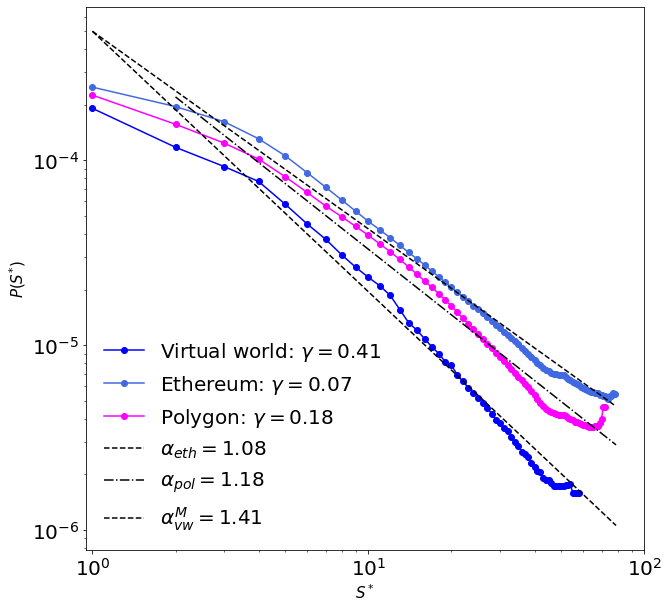

In [97]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

color_leg = ['blue','royalblue','magenta']
labels_leg = [r'Virtual world: $\gamma=0.41$', r'Ethereum: $\gamma = 0.07$',r'Polygon: $\gamma = 0.18$']
for j, cc in enumerate([visit_freq_dict, visit_freq_dict_2, visit_freq_dict_3]):
    mm_counts = []
    mm_err = []
    for i in range(1,len(cc)+1):
        mm_counts.append(np.mean(cc[i]))
        mm_err.append(np.std(cc[i])/np.sqrt(len(cc[i])))
        
    xval = np.arange(1, len(cc)+1)
    mm_counts = np.array(mm_counts)
    
    #if j == 0:
    #    plt.plot(xval, mm_counts*0.7, marker='o', label=labels_leg[j], color=color_leg[j])    
    #else:
    plt.plot(xval, mm_counts, marker='o', label=labels_leg[j], color=color_leg[j])
#    plt.errorbar(xval, mm_counts, yerr=mm_err, marker='o', label=labels_leg[j])

## fit 
popt = [0.0005,1.07]
#popt = [0.22025065, 1.02333805]
xval = np.arange(1, 80)
yval_res = power_law_fit(xval, *popt)    
plt.plot(xval, yval_res, linestyle='--', color='black', label = r'$\alpha_{eth} = 1.08$')

popt = [0.0005,1.18]
#popt = [0.22025065, 1.02333805]
xval = np.arange(2, 80)
yval_res = power_law_fit(xval, *popt)    
plt.plot(xval, yval_res, linestyle='-.', color='black', label = r'$\alpha_{pol} = 1.18$')

popt = [0.0005,1.41]
#popt = [0.22025065, 1.02333805]
xval = np.arange(1, 80)
yval_res = power_law_fit(xval, *popt)    
plt.plot(xval, yval_res, linestyle='--', color='black', label = r'$\alpha^{M}_{vw} = 1.41$')

plt.legend(fontsize=20, frameon=False)
plt.tick_params(labelsize=20)
plt.xlabel(r"$S^*$", fontsize=15)
plt.ylabel(r"$P(S^{*})$", fontsize=15)
plt.loglog()
plt.xlim(0.95,100)
#plt.savefig("plots/si/mepr_model_simulation_s_star.pdf", bbox_inches='tight')
plt.show()

## 2) S(N) vs n

In [7]:
mepr_visited_users['n_locs'] = mepr_visited_users.user_locs.apply(lambda x: len(x))
mepr_visited_users['n_unique_locs'] = mepr_visited_users.user_locs.apply(lambda x: len(set(x)))

t = mepr_visited_users.groupby('n_locs').n_unique_locs.mean().to_frame()
t['n_locs'] = t.index
t.index = range(len(t))
t.columns = ['s_n','n']
t = t.sort_values('n')

xval = t.n
X = np.log(xval)
Y = np.log(np.array(t.s_n))

X = sm.add_constant(X)

model = sm.OLS(Y,X)

res = model.fit()
print(res.params)

c_res_std, beta_res_std = res.params[0], res.params[1] 
c_se_res_std, beta_se_res_std = res.bse[0], res.bse[1]
print(beta_res_std, beta_res_std - 1.96*beta_se_res_std, 
      beta_res_std + 1.96*beta_se_res_std)
print(res.summary())



const   -0.189402
n        0.628592
dtype: float64
0.6285924080532521 0.6194743233862267 0.6377104927202776
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 1.826e+04
Date:                Fri, 19 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:40:27   Log-Likelihood:                 920.81
No. Observations:                 887   AIC:                            -1838.
Df Residuals:                     885   BIC:                            -1828.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [98]:
mepr_visited_users['n_locs'] = mepr_visited_users.user_locs.apply(lambda x: len(x))
mepr_visited_users['n_unique_locs'] = mepr_visited_users.user_locs.apply(lambda x: len(set(x)))

mepr_visited_users_2['n_locs'] = mepr_visited_users_2.user_locs.apply(lambda x: len(x))
mepr_visited_users_2['n_unique_locs'] = mepr_visited_users_2.user_locs.apply(lambda x: len(set(x)))

mepr_visited_users_3['n_locs'] = mepr_visited_users_3.user_locs.apply(lambda x: len(x))
mepr_visited_users_3['n_unique_locs'] = mepr_visited_users_3.user_locs.apply(lambda x: len(set(x)))

mepr_visited_users.head()

,user_id,user_locs,n_locs,n_unique_locs
0,0,"[2038, 2038, 2038, 2038, 2038, 8169, 6847, 542...",833,57
1,1,"[2229, 17370, 2401, 6532, 2401, 2401, 2401, 17...",481,45
2,2,"[3340, 13292, 3340, 3340, 13292, 3340, 5812, 3...",384,32
3,3,"[11658, 8635, 8635, 8635, 11658, 11658, 8635, ...",1010,62
4,4,"[18985, 18129, 10227, 18985, 10227, 10227, 181...",1116,64


In [99]:
t = mepr_visited_users.groupby('n_locs').n_unique_locs.mean().to_frame()
t['n_locs'] = t.index
t.index = range(len(t))
t.columns = ['s_n','n']
t = t.sort_values('n')

t2 = mepr_visited_users_2.groupby('n_locs').n_unique_locs.mean().to_frame()
t2['n_locs'] = t2.index
t2.index = range(len(t2))
t2.columns = ['s_n','n']
t2 = t2.sort_values('n')

t3 = mepr_visited_users_3.groupby('n_locs').n_unique_locs.mean().to_frame()
t3['n_locs'] = t3.index
t3.index = range(len(t3))
t3.columns = ['s_n','n']
t3 = t3.sort_values('n')
t3

,s_n,n
0,9.0,13
1,11.0,31
2,11.0,37
3,13.0,41
4,10.0,42
...,...,...
768,103.0,879
769,104.0,884
770,100.0,888
771,101.0,889


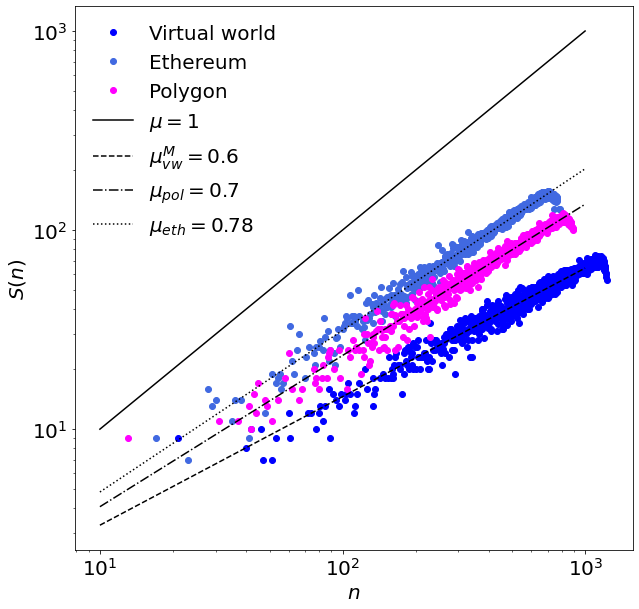

In [117]:
fig = plt.figure(figsize=(10,10))

plt.plot(t.n, t.s_n, marker='o', linestyle='None', color='blue', label='Virtual world')
plt.plot(t2.n, t2.s_n, marker='o', linestyle='None', color='royalblue', label='Ethereum')
plt.plot(t3.n, t3.s_n, marker='o', linestyle='None', color='magenta', label='Polygon')

plt.plot(range(10,1000), range(10, 1000), color='black', label=r'$\mu = 1$')

x_arr = range(10, 1000)
plt.plot(x_arr,[np.exp(np.log(i)*beta_res_std + c_res_std) for i in x_arr], 
         color='black', linestyle='--', label=r'$\mu^{M}_{vw} = 0.6$')

x_arr = range(10, 1000)
plt.plot(x_arr,[np.exp(np.log(i)*beta_res_std_pol + c_res_std_pol) for i in x_arr], 
         color='black', linestyle='-.', label=r'$\mu_{pol} = 0.7$')

x_arr = range(10, 1000)
plt.plot(x_arr,[np.exp(np.log(i)*beta_res_std_eth + c_res_std_eth) for i in x_arr], 
         color='black', linestyle=':', label=r'$\mu_{eth} = 0.78$')

#plt.xlim(500, 10000)
plt.legend(fontsize=20, frameon=False)
plt.tick_params(labelsize=20)
plt.xlabel(r"$n$", fontsize=20)
plt.ylabel(r"$S(n)$", fontsize=20)
plt.loglog()
#plt.savefig('plots/si/mepr_model_simulation_n_s_n.pdf', bbox_inches='tight')
plt.show()

## Macroscopic processes

## get mobility network

In [176]:
from ast import literal_eval

In [177]:
epr_model = pd.read_csv("final-curated-data/epr_model_simulations_0_41_0_85_v2.csv")
epr_model['locs_visited_model_l'] = epr_model.locs_visited_model_l.apply(lambda x: literal_eval(x))

In [178]:
epr_net = epr_model[['peer_address','locs_visited_model_l']].explode("locs_visited_model_l")

g_epr = nx.Graph(weighted = True)

for i in tqdm(range(len(epr_model))):    
    t_l = epr_model.iloc[i]['locs_visited_model_l']
    u_l = epr_model.iloc[i]['peer_address']
    prev_ctr = t_l[0]

    for ii in t_l[1:]:
        if ii != prev_ctr:                
            if not g_epr.has_edge(ii, prev_ctr):
                g_epr.add_edge(ii, prev_ctr, weight = 0)
                #g_epr[ii][prev_ctr]['users'] = []
            
            g_epr[ii][prev_ctr]['weight'] +=1
            #if u_l not in g_epr[ii][prev_ctr]['users']:
            #    g_epr[ii][prev_ctr]['users'].append(u_l)

print(nx.info(g_epr))    

100%|██████████| 1000/1000 [00:01<00:00, 511.14it/s]

Name: 
Type: Graph
Number of nodes: 73555
Number of edges: 157074
Average degree:   4.2709


In [140]:
## get the m-epr model
g_mepr = nx.Graph(weighted = True)

ctr = 0
for i in tqdm(location_users_mepr):
    t_l = i
    if len(t_l)<151: ## get stationary condition
        continue
#    print(len(t_l))
    prev_ctr = t_l[150]
    for ii in t_l[151:]:
        if ii != prev_ctr:                
            if not g_mepr.has_edge(ii, prev_ctr):
                g_mepr.add_edge(ii, prev_ctr, weight = 0)
            g_mepr[ii][prev_ctr]['weight'] +=1
    ctr+=1
print(nx.info(g_mepr))

100%|██████████| 5000/5000 [00:04<00:00, 1151.61it/s]

Name: 
Type: Graph
Number of nodes: 3128
Number of edges: 56209
Average degree:  35.9393


## 1) degree distribution

1 1008
Calculating best minimal value for power law fit
2.1951339167036408


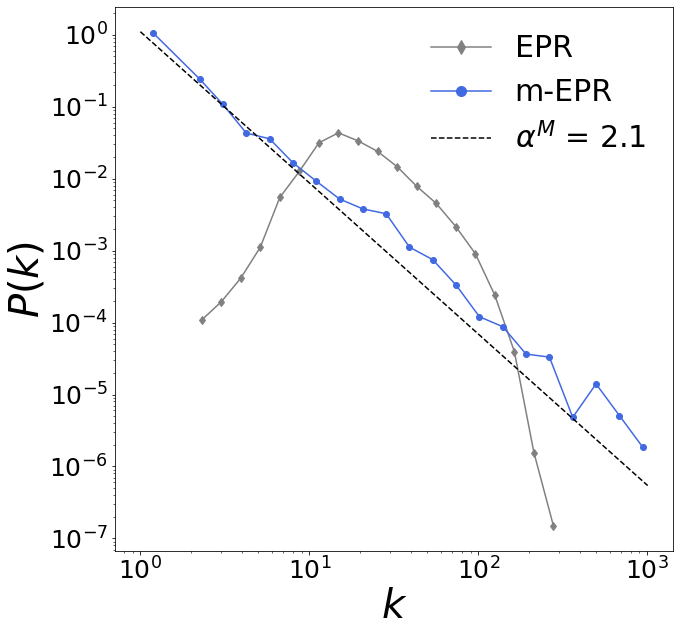

In [119]:
fig = plt.figure(figsize=(10,10))

l = list(dict(g_epr.degree()).values())
x, y= get_distribution(l, density = True, number_of_bins = 28)
plt.plot(x,y, marker='d', color='gray',label='EPR')

l = list(dict(g_mepr.degree()).values())

print(np.min(l), np.max(l))
x, y= get_distribution(l, density = True, number_of_bins = 30)
plt.plot(x,y, marker='o', color='royalblue',label='m-EPR')

fit = powerlaw.Fit(l)
alpha = fit.power_law.alpha
print(alpha)

x = np.arange(np.min(l), np.max(l))
# find the powerlaw fit line
ypowerlaw_fit = (alpha - 1) * (x ** (-alpha))
plt.plot(x, ypowerlaw_fit,linestyle='--', color='black',alpha =1,label = r'$\alpha^{M}$ = 2.1')

plt.loglog()
plt.tick_params(labelsize=25)
plt.xlabel(r"$k$", fontsize=40, labelpad = 2)
plt.ylabel(r"$P(k)$", fontsize=40, labelpad = 2)

lgnd = plt.legend(fontsize=30, frameon=False, markerscale=5, loc=1)

#change the marker size manually for both lines
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(10)

#plt.savefig("plots/pk_dist_model_simulations.pdf", bbox_inches='tight')
plt.show()

## 2) link weight distribution

100%|██████████| 5000/5000 [00:00<00:00, 10778.16it/s]


Calculating best minimal value for power law fit
2.1979541409970524
sigma: 0.03711131416549672


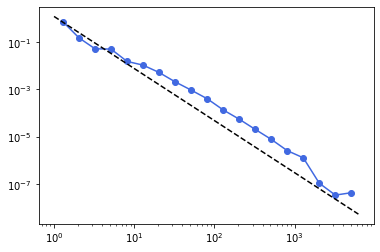

In [205]:
weight_l = []
for i in list(g_mepr.edges(data=True)):
    weight_l.append(i[2]['weight'])
    
l = weight_l
l = [i for i in l if i>0]

x, y= get_distribution(l, density = True, number_of_bins = 25)
plt.plot(x,y, marker='o', color='royalblue', label='m-EPR')

fit = powerlaw.Fit(l)
alpha = fit.power_law.alpha
print(alpha)
print("sigma:", fit.power_law.sigma)

x = np.arange(np.min(l), np.max(l))
# find the powerlaw fit line
ypowerlaw_fit = (alpha - 1)*min(x)**((alpha - 1))*x**(-alpha)

plt.plot(x, ypowerlaw_fit,linestyle='--', 
        color='black',alpha =1,
         label = r'$\alpha$ = 2.8')#+str(round(alpha,1)))

plt.loglog()
plt.show()

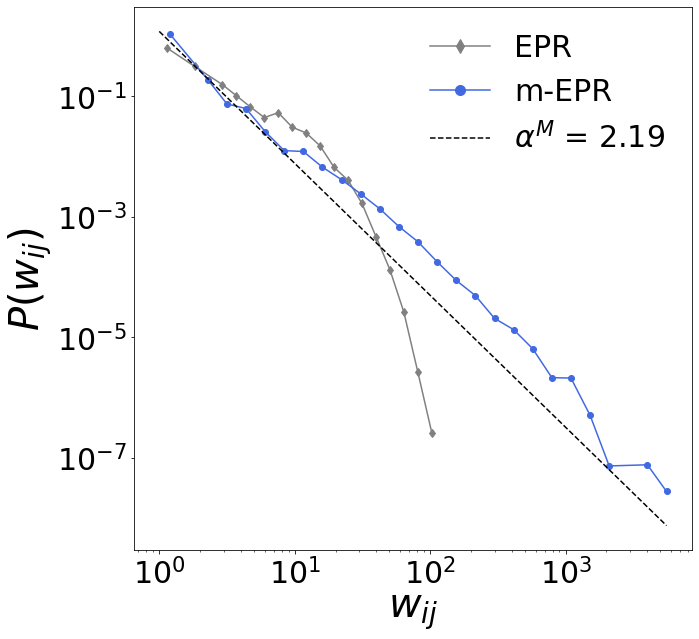

In [217]:
fig = plt.figure(figsize=(10,10))

weight_l = []
for i in list(g_epr.edges(data=True)):
    weight_l.append(i[2]['weight'])
    
l = weight_l
l = [i for i in l if i>0]

x, y= get_distribution(l, density = True, number_of_bins = 30)
plt.plot(x,y, marker='d', color='gray', label='EPR')

weight_l = []

for i in list(g_mepr.edges(data=True)):
    weight_l.append(i[2]['weight'])
    
l = weight_l
l = [i for i in l if i>0]

x, y= get_distribution(l, density = True, number_of_bins = 35)
plt.plot(x,y, marker='o', color='royalblue', label='m-EPR')

fit = powerlaw.Fit(l)
alpha = fit.power_law.alpha
print(alpha)

x = np.arange(1, np.max(x))
#x = np.arange(np.min(l), 5000)

# find the powerlaw fit line
ypowerlaw_fit = (alpha - 1)*min(x)**((alpha - 1))*x**(-alpha)

plt.plot(x, ypowerlaw_fit,linestyle='--', 
        color='black',alpha =1,
         label = r'$\alpha^M$ = '+str(round(alpha,2)))

plt.loglog()
plt.tick_params(labelsize=30)
plt.xlabel(r"$w_{ij}$", fontsize=40, labelpad = 2)
plt.ylabel(r"$P(w_{ij})$", fontsize=40, labelpad = 2)

lgnd = plt.legend(fontsize=30, frameon=False, markerscale=5, loc=1)

#change the marker size manually for both lines
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(10)

#plt.savefig('plots/wij_dist_simulations_2.pdf', bbox_inches='tight')
plt.show()

## 3) N(S) vs k

In [16]:
n_users_epr_df = epr_net.groupby('locs_visited_model_l').peer_address.nunique().to_frame()
n_users_epr_df['l_val'] = n_users_epr_df.index
n_users_epr_df.index = range(len(n_users_epr_df))
n_users_epr_df.columns = ['n_users','locs_id']

n_users_epr = []
k_users_epr = []

for _, r in n_users_epr_df.iterrows():
    n_users_epr.append(r['n_users'])
    k_users_epr.append(g_epr.degree(r['locs_id']))
    
    
n_users_epr_df.head()

,n_users,locs_id
0,156,0
1,105,1
2,84,2
3,79,3
4,64,4


In [24]:
#mepr_visited_users['unique_locs'] = mepr_visited_users.user_locs.apply(lambda x: list(set(x)))
visitors_df = mepr_visited_users[['user_id','user_locs']].explode('user_locs')
visitors_df = visitors_df.groupby('user_locs').user_id.nunique().to_frame()
visitors_df['u_locs'] = visitors_df.index
visitors_df.index = range(len(visitors_df))
visitors_df.columns = ['n_visitors','loc_id']

d_dict = dict(g_mepr.degree())

n_users = []
k_users = []

for _, r in visitors_df.iterrows():
    if r['loc_id'] in d_dict:
        n_users.append(r['n_visitors'])
        k_users.append(d_dict[r['loc_id']])
mepr_k_n_user = pd.DataFrame({"n_users":n_users, 'k_users':k_users})

/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[4.005934718100891, 4.8325537885874645, 7.8244365361803085, 11.533586818757922, 17.82875605815832, 27.713207547169812, 41.128571428571426, 55.299418604651166, 77.57627118644068, 122.20996441281139, 238.88770053475935, 431.875, 858.8783783783783, 2165.3333333333335, 3779.5384615384614, 4961.0, nan, nan, nan]
2691.34046510645
[0.65823257 0.95849587]
0.8896163118107657 1.0273754209425725
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     743.9
Date:                Tue, 05 Dec 2023   Prob (F-statistic):           1.55e-13
Time:                        14:27:00   Log-Likelihood:                -3.8401
No. Observations:                  16   AIC:                             11.68
Df Residuals:                      14   BIC:               

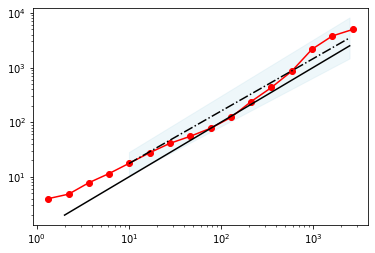

In [27]:
x, y= get_distribution_collection([mepr_k_n_user[mepr_k_n_user.k_users>=1].k_users, 
                                   mepr_k_n_user[mepr_k_n_user.k_users>=1].n_users], number_of_bins = 20)

plt.plot(x, y, color='red', marker='o')
plt.loglog()

print(y)
x = x[:-3]
y = y[:-3]

print(max(x))
X = np.log(np.array(x))
Y = np.log(np.array(y))
X = sm.add_constant(X)

model = sm.OLS(Y,X)

res = model.fit()
print(res.params)

c_res_std, beta_res_std = res.params[0], res.params[1] 
c_se_res_std, beta_se_res_std = res.bse[0], res.bse[1]
print(beta_res_std - 1.96*beta_se_res_std, beta_res_std + 1.96*beta_se_res_std)
print(res.summary())

x_arr = range(10, 2500,10)
plt.plot(x_arr,[np.exp(np.log(i)*(beta_res_std) + c_res_std) for i in x_arr], 
         color='black', 
         linestyle='-.', label=r'$\gamma = 0.93$'+' (0.03)')

y_se_minus_arr = [np.exp(np.log(i)*(beta_res_std - 1.96*beta_se_res_std) + (c_res_std- 1.96*c_se_res_std)) for i in x_arr]
y_se_plus_arr = [np.exp(np.log(i)*(beta_res_std+ 1.96*beta_se_res_std) + (c_res_std + 1.96*c_se_res_std)) for i in x_arr]

plt.fill_between(x_arr, y_se_minus_arr, y_se_plus_arr, alpha = 0.2, color='lightblue')
plt.plot(range(2,2500), range(2, 2500), label = r'$\gamma = 1$', color='black')
plt.show()

/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/shared/centos7/anaconda3/2021.05/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


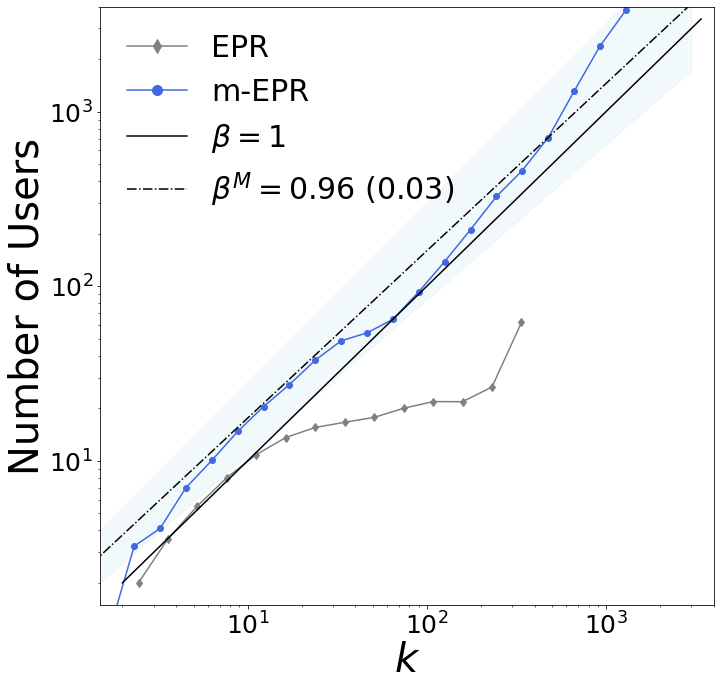

In [42]:
#plt.scatter(k_users, n_users)

fig = plt.figure(figsize=(11,11))

x, y= get_distribution_collection([k_users_epr, n_users_epr], number_of_bins = 20)

plt.plot(x, y, color='gray', marker='d', label = 'EPR')

x, y= get_distribution_collection([mepr_k_n_user[mepr_k_n_user.k_users>=1].k_users, 
                                   mepr_k_n_user[mepr_k_n_user.k_users>=1].n_users], number_of_bins = 30)

#x, y= get_distribution_collection([k_users, n_users], number_of_bins = 22)

x = x[:-7]
y = y[:-7]
y = [i-3 for i in y]
plt.plot(x, y, color='royalblue', marker='o', label='m-EPR')

plt.plot(range(2,3400), range(2, 3400), label = r'$\beta = 1$', color='black')

x_arr = range(1, 3000,10)


plt.plot(x_arr,[np.exp(np.log(i)*(beta_res_std) + c_res_std) for i in x_arr], 
         color='black', 
         linestyle='-.', label=r'$\beta^M = 0.96$'+' (0.03)')

y_se_minus_arr = [np.exp(np.log(i)*(beta_res_std - 1.96*beta_se_res_std) + (c_res_std- 1.96*c_se_res_std)) for i in x_arr]
y_se_plus_arr = [np.exp(np.log(i)*(beta_res_std+ 1.96*beta_se_res_std) + (c_res_std + 1.96*c_se_res_std)) for i in x_arr]

plt.fill_between(x_arr, y_se_minus_arr, y_se_plus_arr, alpha = 0.15, color='lightblue')


plt.tick_params(labelsize=25)
plt.xlabel(r"$k$", fontsize=40, labelpad = 2)
plt.ylabel("Number of Users", fontsize=40, labelpad = 2)

plt.xlim(1.5, 4000)
plt.ylim(1.5,4000)

lgnd = plt.legend(fontsize=30, frameon=False, markerscale=5, loc=2)

#change the marker size manually for both lines
for lh in lgnd.legendHandles:
    lh._legmarker.set_markersize(10)

#plt.plot(range(1,1000), range(1,1000))
plt.loglog()

#plt.savefig('plots/k_n_users_dist_simulations.pdf', bbox_inches='tight')
plt.show()